In [3]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf

from nltk.tokenize import TweetTokenizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import word_tokenize, NLTKWordTokenizer
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, Embedding

from keras.callbacks import EarlyStopping

import nltk
from numpy.ma.core import sqrt
from sklearn.utils import shuffle
import time
from sklearn.model_selection import KFold

In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

In [11]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

In [4]:
incsv=pd.read_csv('updated_code_mix_abusive.csv')
incsv.sample(5)

,conversation_id,tweet,abusive
6862,1.465929e+18,@sudhirchaudhary Hey Tihari Chaudhary you re #...,1
29792,9.810842e+17,@CaAbhisheksahay @VikasDewasi1 @imVkohi @SAfri...,1
1460,1.460560e+18,@thevirdas I am with u.. media bick gai hai sa...,0
23122,1.451041e+18,@PradeepNBaliya @captgrc @anjanaomkashyap kami...,0
31362,9.810842e+17,@fahad28001 @tahirrhussain @Ahsanul61016956 @S...,1


In [6]:
sample = incsv.sample(50)
sample.drop(axis=1, columns=['conversation_id'],)
sample.to_csv('sample_code_mix_abusive.csv', index=False)

In [ ]:
#Load Hatespeeech dataset for comparison
df = pd.read_csv('hatespeech_dataset.csv')
df.dropna(inplace=True)
df = df[~df.tweet.str.contains("Error")]
#convert datatype
convert_dict = {'label':int}
df = df.astype(convert_dict)
df.rename(columns = {'label':'hate'}, inplace=True)
df.reset_index(inplace=True, drop=True)

incsv = df
del(df)

In [5]:
incsv['abusive'].value_counts()

1    20328
0    16095
Name: abusive, dtype: int64

### Pre-Processing

In [17]:
!pip install emoji
import emoji
import re

In [9]:
#not needed now
FLAGS = re.MULTILINE | re.DOTALL
def emotize(text):
    t1 = emoji.replace_emoji(text,' emoji ')
    t2 = re.sub(r'🇦', 'A', t1, flags=FLAGS)
    t3 = re.sub(r'🇧', 'B', t2, flags=FLAGS)
    t4 = re.sub(r'🇨', 'C', t3, flags=FLAGS)
    t5 = re.sub(r'🇩', 'D', t4, flags=FLAGS)
    T6 = re.sub(r'🇪', 'E', t5, flags=FLAGS)
    t7 = re.sub(r'🇫', 'F', t5, flags=FLAGS)
    t8 = re.sub(r'🇬', 'G', t7, flags=FLAGS)
    t9 = re.sub(r'🇭', 'H', t8, flags=FLAGS)
    t10 = re.sub(r'🇮', 'I', t9, flags=FLAGS)
    t11 = re.sub(r'🇯', 'J', t10, flags=FLAGS)
    t12 = re.sub(r'🇰', 'K', t11, flags=FLAGS)
    t13 = re.sub(r'🇱', 'L', t12, flags=FLAGS)
    t14 = re.sub(r'🇲', 'M', t13, flags=FLAGS)
    t15 = re.sub(r'🇳', 'N', t14, flags=FLAGS)
    t16 = re.sub(r'🇴', 'O', t15, flags=FLAGS)
    t17 = re.sub(r'🇵', 'P', t16, flags=FLAGS)
    t18 = re.sub(r'🇶', 'Q', t17, flags=FLAGS)
    t19 = re.sub(r'🇷', 'R', t18, flags=FLAGS)
    t20 = re.sub(r'🇸', 'S', t19, flags=FLAGS)
    t21 = re.sub(r'🇹', 'T', t20, flags=FLAGS)
    t22 = re.sub(r'🇺', 'U', t21, flags=FLAGS)
    t23 = re.sub(r'🇻', 'V', t22, flags=FLAGS)
    t24 = re.sub(r'🇼', 'W', t23, flags=FLAGS)
    t25 = re.sub(r'🇽', 'X', t24, flags=FLAGS)
    t26 = re.sub(r'🇾', 'Y', t25, flags=FLAGS)
    t27 = re.sub(r'🇿', 'Z', t26, flags=FLAGS)

    #t28 = re.sub(r"@\w+", "@u",t27,flags=FLAGS)
    return t27

In [15]:
tknzr=WhitespaceTokenizer()
def text_preprocess(text, tknzr):
    FLAGS = re.MULTILINE | re.DOTALL
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = emotize(text)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "url")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "") #removed username
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "smile")
    text = re_sub(r"{}{}p+".format(eyes, nose), "lolface")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "sadface")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "neutralface")
    text = re_sub(r"<3","heart")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "number") #number
    text = re_sub(r"[A-Za-z]+[@#$%^&*()]+[A-Za-z]*","abuse")
    #text = re_sub(r"#\S+", lambda hashtag: " ".join(segment(hashtag.group()[1:]))) # segment hastags

    tokens = tknzr.tokenize(text.lower())

    return " ".join(tokens)

In [18]:
for line in range (0,len(incsv)):
  sent = incsv['tweet'].iloc[line]
  sent = sent.lower()
  sent = text_preprocess(sent,tknzr)
  incsv.at[line, 'tweet'] = sent
del(emoji)

#### Word Cloud

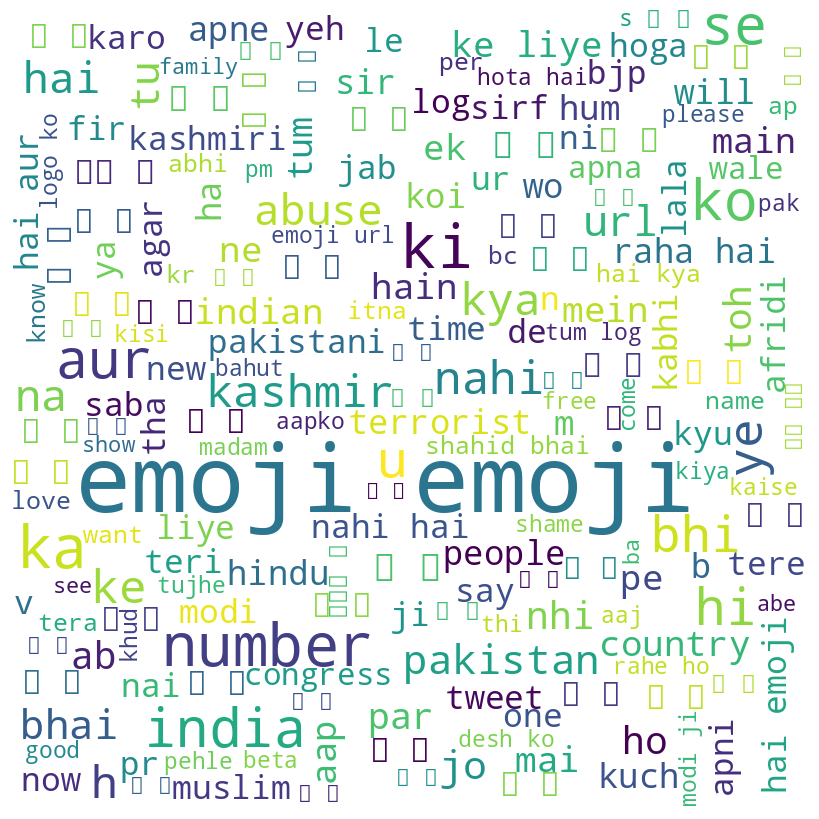

In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Reads 'Youtube04-Eminem.csv' file
df = incsv

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.tweet:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = 'White')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [6]:
oov='UNK'
tokenizer_w = WhitespaceTokenizer()
#tokenizer_w= word_tokenize
tokenizer = Tokenizer(oov_token=oov)
a=set()
b=set()
for i in range(0,len(incsv)):
  b=tokenizer_w.tokenize(incsv.iloc[i]['tweet'])
  #b=tokenizer_w.tokenize(train[i])
  a=a.union(b)
  #print(b)
  b=set()
#.split() misbehaving for space.
i=0
for token in a:
  tokenizer.index_word[i]=token
  tokenizer.word_index[token]=i
  i+=1

print('number of tokens', len(a))

number of tokens 115948


<Axes: >

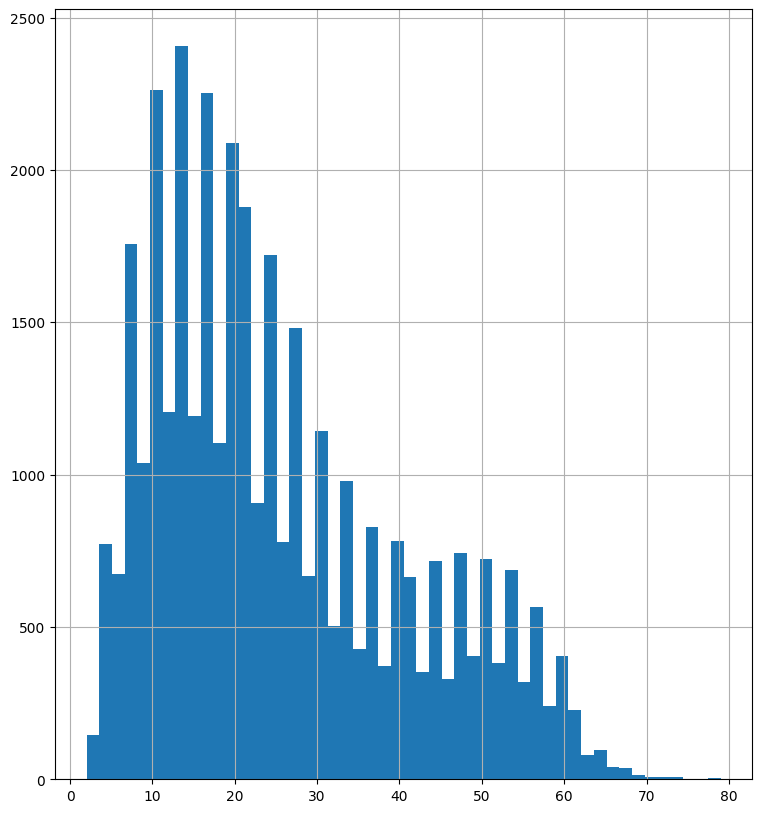

In [7]:
tokenizer.fit_on_texts(incsv['tweet'])

word_index=tokenizer.word_index
vocabulary_size=len(word_index)+1
sequences = tokenizer.texts_to_sequences(incsv['tweet'])
seq_len = [len(i) for i in sequences]

pd.Series(seq_len).hist(bins=50,figsize=(9,10))

## Training



In [10]:
def prdt(predict):
  y_pred=[]
  for i in range(0,len(predict)):
    if predict[i]>0.50:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return y_pred

### without embedding

In [15]:
num_folds = 5
tokenizers = ['TweetTokenizer','WhitespaceTokenizer','word_tokenize']
result_dataframe = pd.DataFrame(columns=['key','tokenizer', 'technique', 'mcc','m_f1','w_f1', 'acc'])
# Create the K-fold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
key=1
for train_index, test_index in kf.split(incsv):

  train = incsv.iloc[train_index]
  test = incsv.iloc[test_index]
  start = time.time()

  num_class = 1

  #tokenizer decision
  oov='UNK'
  #Set the tokenizer
  for tknzr_list in tokenizers:
    tokenizer_w=[]
    tokenizer=[]
    if tknzr_list == 'TweetTokenizer':
      tokenizer_w = TweetTokenizer()
    elif tknzr_list == 'WhitespaceTokenizer':
      tokenizer_w = WhitespaceTokenizer()
    elif tknzr_list == 'word_tokenize':
      tokenizer_w = NLTKWordTokenizer()

    #train-test split

    X_train=train['tweet']
    y_train=np.array(train['abusive'])

    X_test=test['tweet']
    y_test=np.array(test['abusive'])

    #tokenizer and text to index conversion

    tokenizer = Tokenizer(oov_token=oov)
    a=set()
    b=set()
    for twt in X_train:
      b = tokenizer_w.tokenize(twt)
      a = a.union(b)
      #print(b)
      b = set()
    #.split() misbehaving for space.
    i=0
    for token in a:
      tokenizer.index_word[i]=token
      tokenizer.word_index[token]=i
      i+=1

    print('number of tokens', len(a))
    tokenizer.fit_on_texts(X_train)

    word_index=tokenizer.word_index
    vocabulary_size=len(word_index)+1
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)
    vector_size=100

    X_train_data = pad_sequences(train_sequences, maxlen=vector_size, padding='post',truncating='pre')
    X_test_data = pad_sequences(test_sequences, maxlen=vector_size, padding='post')
    #Training


    ##Pyramid
    model = Sequential()
    model.add(Embedding(vocabulary_size, input_length=vector_size,trainable=True,output_dim=256))
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
    callbacks_list = [early_stopping]
    ###Training
    history = model.fit(X_train_data, y_train, validation_split =0.1, epochs = 50, callbacks=callbacks_list, batch_size=4048)
    ###Evaluation
    predict = model.predict(X_test_data)
    y_pred=prdt(predict)
    report_pyramid = classification_report(y_test, y_pred, output_dict = True)
    mcc_pyramid = matthews_corrcoef(y_test, y_pred)
    del(model)


    ## LSTM
    model = Sequential()
    model.add(Embedding(vocabulary_size, input_length=vector_size,trainable=True,output_dim=256))
    model.add(LSTM(512, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(num_class, activation='sigmoid'))#num_class

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
    callbacks_list = [early_stopping]
    ###Training
    history = model.fit(X_train_data, y_train, validation_split =0.1, epochs = 50, callbacks=callbacks_list, batch_size=3048)
    ###Evaluation
    predict = model.predict(X_test_data)
    y_pred=prdt(predict)
    report_LSTM = classification_report(y_test, y_pred, output_dict = True)
    mcc_LSTM = matthews_corrcoef(y_test, y_pred)
    del(model)

    ## BiLSTM
    model = Sequential()
    model.add(Embedding(vocabulary_size, input_length=vector_size,trainable=True,output_dim=256))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(num_class, activation='sigmoid'))#num_class

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, restore_best_weights=True)
    callbacks_list = [early_stopping]
    ###Training
    history = model.fit(train_data, train_data_label, validation_split=0.1, epochs = 50, callbacks=callbacks_list, batch_size=2048)
    ###Evaluation
    predict = model.predict(test_data)
    y_pred=prdt(predict)
    report_BiLSTM = classification_report(test_data_label, y_pred, output_dict = True)
    mcc_BiLSTM = matthews_corrcoef(test_data_label, y_pred)
    del(model)


    ##CNN
    model = Sequential()
    model.add(Embedding(vocabulary_size, input_length=vector_size,trainable=True,output_dim=256))
    model.add(Conv1D(filters=128, kernel_size=8, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_class, activation='sigmoid'))#num_class

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
    callbacks_list = [early_stopping]
    ###Training
    history = model.fit(X_train_data, y_train, validation_split =0.1, epochs = 50, callbacks=callbacks_list, batch_size=4048)
    ###Evaluation
    predict = model.predict(X_test_data)
    y_pred=prdt(predict)
    report_CNN = classification_report(y_test, y_pred, output_dict = True)
    mcc_CNN = matthews_corrcoef(y_test, y_pred)
    del(model)
    #ML Methods
    train_data = X_train_data
    train_data_label = y_train

    test_data = X_test_data
    test_data_label = y_test
    ovr = OneVsRestClassifier(estimator=GradientBoostingClassifier())
    ovr.fit(train_data, train_data_label)
    predict = ovr.predict(test_data)
    y_pred=prdt(predict)
    mcc_GB = matthews_corrcoef(test_data_label, y_pred)
    report_GB = classification_report(test_data_label, y_pred, output_dict = True)
    del(ovr)

    ovr = OneVsRestClassifier(estimator=SGDClassifier())
    ovr.fit(train_data, train_data_label)
    predict = ovr.predict(test_data)
    y_pred=prdt(predict)
    mcc_SGDC = matthews_corrcoef(test_data_label, y_pred)
    report_SGDC = classification_report(test_data_label, y_pred, output_dict = True)
    del(ovr)

    ovo = OneVsOneClassifier(estimator=LogisticRegression())
    ovo.fit(train_data, train_data_label)
    predict = ovo.predict(test_data)
    y_pred=prdt(predict)
    mcc_LR = matthews_corrcoef(test_data_label, y_pred)
    report_LR = classification_report(test_data_label, y_pred, output_dict = True)
    del(ovo)

    ovo = OneVsOneClassifier(estimator=KNeighborsClassifier(n_neighbors=2))
    ovo.fit(train_data, train_data_label)
    predict = ovo.predict(test_data)
    y_pred=prdt(predict)
    mcc_KNN = matthews_corrcoef(test_data_label, y_pred)
    report_KNN = classification_report(test_data_label, y_pred, output_dict = True)
    del(ovo)

    ovo = OneVsOneClassifier(estimator=BernoulliNB())
    ovo.fit(train_data, train_data_label)
    predict = ovo.predict(test_data)
    y_pred=prdt(predict)
    mcc_BNB = matthews_corrcoef(test_data_label, y_pred)
    report_BNB = classification_report(test_data_label, y_pred, output_dict = True)
    del(ovo)

    rfc = RandomForestClassifier(max_depth = 10)
    rfc.fit(train_data, train_data_label)
    predict = rfc.predict(test_data)
    y_pred=prdt(predict)
    mcc_rfc = matthews_corrcoef(test_data_label, y_pred)
    report_rfc = classification_report(test_data_label, y_pred, output_dict = True)
    del(rfc)


    result_row1={'key':key,'tokenizer':tknzr_list, 'technique':'LSTM', 'mcc':mcc_LSTM,'m_f1':report_LSTM['macro avg']['f1-score'],
                'w_f1':report_LSTM['weighted avg']['f1-score'], 'acc':report_LSTM['accuracy']}

    result_row2={'key':key,'tokenizer':tknzr_list, 'technique':'GB', 'mcc':mcc_GB,'m_f1':report_GB['macro avg']['f1-score'],
                'w_f1':report_GB['weighted avg']['f1-score'], 'acc':report_GB['accuracy']}
    result_row3={'key':key,'tokenizer':tknzr_list, 'technique':'SGDC', 'mcc':mcc_SGDC,'m_f1':report_SGDC['macro avg']['f1-score'],
                'w_f1':report_SGDC['weighted avg']['f1-score'], 'acc':report_SGDC['accuracy']}
    result_row4={'key':key,'tokenizer':tknzr_list, 'technique':'LR', 'mcc':mcc_LR,'m_f1':report_LR['macro avg']['f1-score'],
                'w_f1':report_LR['weighted avg']['f1-score'], 'acc':report_LR['accuracy']}
    result_row5={'key':key,'tokenizer':tknzr_list, 'technique':'KNN', 'mcc':mcc_KNN,'m_f1':report_KNN['macro avg']['f1-score'],
                'w_f1':report_KNN['weighted avg']['f1-score'], 'acc':report_KNN['accuracy']}
    result_row6={'key':key,'tokenizer':tknzr_list, 'technique':'BNB', 'mcc':mcc_BNB,'m_f1':report_BNB['macro avg']['f1-score'],
                'w_f1':report_BNB['weighted avg']['f1-score'], 'acc':report_BNB['accuracy']}
    result_row7={'key':key,'tokenizer':tknzr_list, 'technique':'CNN', 'mcc':mcc_CNN,'m_f1':report_CNN['macro avg']['f1-score'],
                'w_f1':report_CNN['weighted avg']['f1-score'], 'acc':report_CNN['accuracy']}
    result_row8={'key':key,'tokenizer':tknzr_list, 'technique':'Pyramid', 'mcc':mcc_pyramid,'m_f1':report_pyramid['macro avg']['f1-score'],
                'w_f1':report_pyramid['weighted avg']['f1-score'], 'acc':report_pyramid['accuracy']}
    result_row9={'key':key,'tokenizer':tknzr_list, 'technique':'Random_Forest', 'mcc':mcc_rfc,'m_f1':report_rfc['macro avg']['f1-score'],
                'w_f1':report_rfc['weighted avg']['f1-score'], 'acc':report_rfc['accuracy']}

    result_dataframe = result_dataframe.append(result_row1, ignore_index=True)

    result_dataframe = result_dataframe.append(result_row2, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row3, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row4, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row5, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row6, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row7, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row8, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row9, ignore_index=True)


  end = time.time()
  print('Time taken for one key is ',(end-start)/60)
  key+=1
  #saving the results wrt key

number of tokens 55241
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6927 - accuracy: 0.5362 - val_loss: 0.5583 - val_accuracy: 0.9849
Epoch 2/50
9/9 [==============================] - 8s 887ms/step - loss: 0.6395 - accuracy: 0.6192 - val_loss: 0.6297 - val_accuracy: 0.6445
Epoch 3/50
9/9 [==============================] - 9s 1s/step - loss: 0.5342 - accuracy: 0.7345 - val_loss: 0.3348 - val_accuracy: 0.8576
Epoch 4/50
9/9 [==============================] - 9s 984ms/step - loss: 0.3944 - accuracy: 0.8282 - val_loss: 0.3163 - val_accuracy: 0.8699
Epoch 5/50
9/9 [==============================] - 8s 880ms/step - loss: 0.2884 - accuracy: 0.8870 - val_loss: 0.3281 - val_accuracy: 0.8593
Epoch 6/50
9/9 [==============================] - 9s 1s/step - loss: 0.1980 - accuracy: 0.9228 - val_loss: 0.3436 - val_accuracy: 0.8730
Epoch 7/50
9/9 [==============================] - 8s 901ms/step - loss: 0.1313 - accuracy: 0.9496 - val_loss: 0.4188 - val_accuracy: 0.8586
Epoch

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 76843
Epoch 1/50
9/9 [==============================] - 11s 951ms/step - loss: 0.6930 - accuracy: 0.5329 - val_loss: 0.5783 - val_accuracy: 0.9581
Epoch 2/50
9/9 [==============================] - 9s 1s/step - loss: 0.6236 - accuracy: 0.6587 - val_loss: 0.3963 - val_accuracy: 0.8981
Epoch 3/50
9/9 [==============================] - 9s 975ms/step - loss: 0.5114 - accuracy: 0.7831 - val_loss: 0.2451 - val_accuracy: 0.9128
Epoch 4/50
9/9 [==============================] - 8s 952ms/step - loss: 0.3696 - accuracy: 0.8373 - val_loss: 0.2792 - val_accuracy: 0.8717
Epoch 5/50
9/9 [==============================] - 9s 996ms/step - loss: 0.2595 - accuracy: 0.8968 - val_loss: 0.3112 - val_accuracy: 0.8655
Epoch 6/50
9/9 [==============================] - 9s 1s/step - loss: 0.1728 - accuracy: 0.9344 - val_loss: 0.3859 - val_accuracy: 0.8418
Epoch 7/50
9/9 [==============================] - 9s 971ms/step - loss: 0.1163 - accuracy: 0.9589 - val_loss: 0.4639 - val_accuracy: 0.8521
Ep

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 59217
Epoch 1/50
9/9 [==============================] - 11s 1s/step - loss: 0.6913 - accuracy: 0.5331 - val_loss: 0.6213 - val_accuracy: 0.8068
Epoch 2/50
9/9 [==============================] - 10s 1s/step - loss: 0.7137 - accuracy: 0.6575 - val_loss: 0.6820 - val_accuracy: 0.5535
Epoch 3/50
9/9 [==============================] - 9s 996ms/step - loss: 0.5736 - accuracy: 0.7192 - val_loss: 0.3442 - val_accuracy: 0.8665
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.3995 - accuracy: 0.8212 - val_loss: 0.2858 - val_accuracy: 0.8809
Epoch 5/50
9/9 [==============================] - 10s 1s/step - loss: 0.2814 - accuracy: 0.8862 - val_loss: 0.2903 - val_accuracy: 0.8768
Epoch 6/50
9/9 [==============================] - 8s 932ms/step - loss: 0.1874 - accuracy: 0.9261 - val_loss: 0.3893 - val_accuracy: 0.8480
Epoch 7/50
9/9 [==============================] - 9s 1s/step - loss: 0.1277 - accuracy: 0.9525 - val_loss: 0.5017 - val_accuracy: 0.8542
Epoch 8/

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 55087
Epoch 1/50
9/9 [==============================] - 13s 1s/step - loss: 0.6955 - accuracy: 0.5285 - val_loss: 0.6202 - val_accuracy: 0.8325
Epoch 2/50
9/9 [==============================] - 9s 990ms/step - loss: 0.6649 - accuracy: 0.6581 - val_loss: 0.4683 - val_accuracy: 0.9417
Epoch 3/50
9/9 [==============================] - 11s 1s/step - loss: 0.5293 - accuracy: 0.7753 - val_loss: 0.2805 - val_accuracy: 0.8892
Epoch 4/50
9/9 [==============================] - 9s 1s/step - loss: 0.3624 - accuracy: 0.8461 - val_loss: 0.2803 - val_accuracy: 0.8782
Epoch 5/50
9/9 [==============================] - 9s 1s/step - loss: 0.2522 - accuracy: 0.8979 - val_loss: 0.3755 - val_accuracy: 0.8473
Epoch 6/50
9/9 [==============================] - 9s 1s/step - loss: 0.1670 - accuracy: 0.9357 - val_loss: 0.4280 - val_accuracy: 0.8394
Epoch 7/50
9/9 [==============================] - 8s 931ms/step - loss: 0.1159 - accuracy: 0.9583 - val_loss: 0.7237 - val_accuracy: 0.8157
Epoch 8/50

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 76643
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6900 - accuracy: 0.5354 - val_loss: 0.5654 - val_accuracy: 0.8754
Epoch 2/50
9/9 [==============================] - 9s 1s/step - loss: 0.6539 - accuracy: 0.6592 - val_loss: 0.5670 - val_accuracy: 0.7889
Epoch 3/50
9/9 [==============================] - 10s 1s/step - loss: 0.5191 - accuracy: 0.7571 - val_loss: 0.3530 - val_accuracy: 0.8336
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.3739 - accuracy: 0.8339 - val_loss: 0.3078 - val_accuracy: 0.8634
Epoch 5/50
9/9 [==============================] - 9s 1s/step - loss: 0.2624 - accuracy: 0.8938 - val_loss: 0.3345 - val_accuracy: 0.8596
Epoch 6/50
9/9 [==============================] - 9s 1s/step - loss: 0.1758 - accuracy: 0.9328 - val_loss: 0.4069 - val_accuracy: 0.8452
Epoch 7/50
9/9 [==============================] - 8s 935ms/step - loss: 0.1196 - accuracy: 0.9557 - val_loss: 0.5951 - val_accuracy: 0.8274
Epoch 8/50
9

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 58972
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6926 - accuracy: 0.5270 - val_loss: 0.5838 - val_accuracy: 0.8950
Epoch 2/50
9/9 [==============================] - 9s 1s/step - loss: 0.6435 - accuracy: 0.6405 - val_loss: 0.5404 - val_accuracy: 0.8051
Epoch 3/50
9/9 [==============================] - 10s 1s/step - loss: 0.5436 - accuracy: 0.7402 - val_loss: 0.2481 - val_accuracy: 0.9104
Epoch 4/50
9/9 [==============================] - 9s 1s/step - loss: 0.4236 - accuracy: 0.8090 - val_loss: 0.3159 - val_accuracy: 0.8682
Epoch 5/50
9/9 [==============================] - 9s 1s/step - loss: 0.3155 - accuracy: 0.8710 - val_loss: 0.3006 - val_accuracy: 0.8693
Epoch 6/50
9/9 [==============================] - 9s 1s/step - loss: 0.2198 - accuracy: 0.9174 - val_loss: 0.4186 - val_accuracy: 0.8445
Epoch 7/50
9/9 [==============================] - 9s 962ms/step - loss: 0.1518 - accuracy: 0.9436 - val_loss: 0.4298 - val_accuracy: 0.8542
Epoch 8/50
9/

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


Time taken for one key is  7.45825982093811
number of tokens 55338
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6957 - accuracy: 0.5179 - val_loss: 0.5992 - val_accuracy: 0.9550
Epoch 2/50
9/9 [==============================] - 9s 985ms/step - loss: 0.6575 - accuracy: 0.6250 - val_loss: 0.6397 - val_accuracy: 0.6500
Epoch 3/50
9/9 [==============================] - 9s 1s/step - loss: 0.5553 - accuracy: 0.7159 - val_loss: 0.3955 - val_accuracy: 0.8226
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.4077 - accuracy: 0.8198 - val_loss: 0.2538 - val_accuracy: 0.8991
Epoch 5/50
9/9 [==============================] - 9s 1s/step - loss: 0.3034 - accuracy: 0.8781 - val_loss: 0.2673 - val_accuracy: 0.8916
Epoch 6/50
9/9 [==============================] - 9s 1s/step - loss: 0.2126 - accuracy: 0.9173 - val_loss: 0.3270 - val_accuracy: 0.8782
Epoch 7/50
9/9 [==============================] - 9s 990ms/step - loss: 0.1481 - accuracy: 0.9443 - val_lo

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 76997
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6913 - accuracy: 0.5329 - val_loss: 0.6186 - val_accuracy: 0.8892
Epoch 2/50
9/9 [==============================] - 9s 967ms/step - loss: 0.6620 - accuracy: 0.6629 - val_loss: 0.6297 - val_accuracy: 0.6764
Epoch 3/50
9/9 [==============================] - 9s 1s/step - loss: 0.5262 - accuracy: 0.7500 - val_loss: 0.3068 - val_accuracy: 0.8638
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.3750 - accuracy: 0.8352 - val_loss: 0.3051 - val_accuracy: 0.8638
Epoch 5/50
9/9 [==============================] - 9s 959ms/step - loss: 0.2644 - accuracy: 0.8936 - val_loss: 0.3140 - val_accuracy: 0.8665
Epoch 6/50
9/9 [==============================] - 10s 1s/step - loss: 0.1813 - accuracy: 0.9302 - val_loss: 0.3983 - val_accuracy: 0.8473
Epoch 7/50
9/9 [==============================] - 8s 930ms/step - loss: 0.1236 - accuracy: 0.9537 - val_loss: 0.4392 - val_accuracy: 0.8535
Epoch 

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 59260
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6910 - accuracy: 0.5298 - val_loss: 0.6095 - val_accuracy: 0.8559
Epoch 2/50
9/9 [==============================] - 9s 1s/step - loss: 0.6928 - accuracy: 0.5895 - val_loss: 0.7449 - val_accuracy: 0.4118
Epoch 3/50
9/9 [==============================] - 9s 978ms/step - loss: 0.6145 - accuracy: 0.6799 - val_loss: 0.5417 - val_accuracy: 0.8154
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.4862 - accuracy: 0.7842 - val_loss: 0.2494 - val_accuracy: 0.9046
Epoch 5/50
9/9 [==============================] - 10s 1s/step - loss: 0.3598 - accuracy: 0.8469 - val_loss: 0.2639 - val_accuracy: 0.8943
Epoch 6/50
9/9 [==============================] - 9s 1s/step - loss: 0.2580 - accuracy: 0.8981 - val_loss: 0.3405 - val_accuracy: 0.8586
Epoch 7/50
9/9 [==============================] - 9s 1s/step - loss: 0.1790 - accuracy: 0.9341 - val_loss: 0.4539 - val_accuracy: 0.8579
Epoch 8/50
9

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


Time taken for one key is  6.456244997183481
number of tokens 55261
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6960 - accuracy: 0.5242 - val_loss: 0.6906 - val_accuracy: 0.5645
Epoch 2/50
9/9 [==============================] - 9s 987ms/step - loss: 0.6454 - accuracy: 0.6450 - val_loss: 0.4487 - val_accuracy: 0.9293
Epoch 3/50
9/9 [==============================] - 10s 1s/step - loss: 0.5593 - accuracy: 0.7340 - val_loss: 0.2357 - val_accuracy: 0.9204
Epoch 4/50
9/9 [==============================] - 9s 1s/step - loss: 0.4048 - accuracy: 0.8220 - val_loss: 0.2840 - val_accuracy: 0.8837
Epoch 5/50
9/9 [==============================] - 9s 988ms/step - loss: 0.2942 - accuracy: 0.8844 - val_loss: 0.3289 - val_accuracy: 0.8473
Epoch 6/50
9/9 [==============================] - 9s 923ms/step - loss: 0.2008 - accuracy: 0.9234 - val_loss: 0.4013 - val_accuracy: 0.8504
Epoch 7/50
9/9 [==============================] - 8s 917ms/step - loss: 0.1366 - accuracy: 0.9484 -

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 76876
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6960 - accuracy: 0.5208 - val_loss: 0.7160 - val_accuracy: 0.3240
Epoch 2/50
9/9 [==============================] - 9s 982ms/step - loss: 0.6570 - accuracy: 0.6466 - val_loss: 0.6149 - val_accuracy: 0.7056
Epoch 3/50
9/9 [==============================] - 10s 1s/step - loss: 0.5437 - accuracy: 0.7336 - val_loss: 0.9348 - val_accuracy: 0.5460
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.5034 - accuracy: 0.7680 - val_loss: 0.2806 - val_accuracy: 0.9221
Epoch 5/50
9/9 [==============================] - 10s 1s/step - loss: 0.3929 - accuracy: 0.8336 - val_loss: 0.3308 - val_accuracy: 0.8452
Epoch 6/50
9/9 [==============================] - 9s 978ms/step - loss: 0.2955 - accuracy: 0.8769 - val_loss: 0.3255 - val_accuracy: 0.8514
Epoch 7/50
9/9 [==============================] - 9s 1s/step - loss: 0.2106 - accuracy: 0.9174 - val_loss: 0.3341 - val_accuracy: 0.8500
Epoch 8/

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 59126
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6954 - accuracy: 0.5186 - val_loss: 0.6417 - val_accuracy: 0.8445
Epoch 2/50
9/9 [==============================] - 9s 971ms/step - loss: 0.6636 - accuracy: 0.6496 - val_loss: 0.4367 - val_accuracy: 0.9499
Epoch 3/50
9/9 [==============================] - 11s 1s/step - loss: 0.5827 - accuracy: 0.7324 - val_loss: 0.3486 - val_accuracy: 0.9056
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.4103 - accuracy: 0.8199 - val_loss: 0.2883 - val_accuracy: 0.8830
Epoch 5/50
9/9 [==============================] - 10s 1s/step - loss: 0.3034 - accuracy: 0.8774 - val_loss: 0.3198 - val_accuracy: 0.8569
Epoch 6/50
9/9 [==============================] - 9s 933ms/step - loss: 0.2124 - accuracy: 0.9173 - val_loss: 0.3676 - val_accuracy: 0.8480
Epoch 7/50
9/9 [==============================] - 9s 1s/step - loss: 0.1441 - accuracy: 0.9457 - val_loss: 0.4405 - val_accuracy: 0.8346
Epoch 8/

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


Time taken for one key is  7.632175477345784
number of tokens 55404
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6962 - accuracy: 0.5211 - val_loss: 0.6735 - val_accuracy: 0.7172
Epoch 2/50
9/9 [==============================] - 9s 1s/step - loss: 0.6452 - accuracy: 0.6580 - val_loss: 0.5224 - val_accuracy: 0.8699
Epoch 3/50
9/9 [==============================] - 10s 1s/step - loss: 0.5629 - accuracy: 0.7354 - val_loss: 0.2791 - val_accuracy: 0.9077
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.4046 - accuracy: 0.8243 - val_loss: 0.2983 - val_accuracy: 0.8765
Epoch 5/50
9/9 [==============================] - 9s 1s/step - loss: 0.2986 - accuracy: 0.8837 - val_loss: 0.3170 - val_accuracy: 0.8679
Epoch 6/50
9/9 [==============================] - 10s 1s/step - loss: 0.2012 - accuracy: 0.9215 - val_loss: 0.3467 - val_accuracy: 0.8531
Epoch 7/50
9/9 [==============================] - 9s 1s/step - loss: 0.1368 - accuracy: 0.9484 - val_loss:

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 76996
Epoch 1/50
9/9 [==============================] - 13s 1s/step - loss: 0.6894 - accuracy: 0.5430 - val_loss: 0.6023 - val_accuracy: 0.8717
Epoch 2/50
9/9 [==============================] - 9s 1s/step - loss: 0.6810 - accuracy: 0.6839 - val_loss: 0.5768 - val_accuracy: 0.8082
Epoch 3/50
9/9 [==============================] - 9s 1s/step - loss: 0.5599 - accuracy: 0.7653 - val_loss: 0.4142 - val_accuracy: 0.8318
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.4120 - accuracy: 0.8209 - val_loss: 0.3501 - val_accuracy: 0.8360
Epoch 5/50
9/9 [==============================] - 10s 1s/step - loss: 0.3069 - accuracy: 0.8810 - val_loss: 0.3110 - val_accuracy: 0.8521
Epoch 6/50
9/9 [==============================] - 9s 992ms/step - loss: 0.2186 - accuracy: 0.9127 - val_loss: 0.3463 - val_accuracy: 0.8596
Epoch 7/50
9/9 [==============================] - 9s 985ms/step - loss: 0.1479 - accuracy: 0.9444 - val_loss: 0.4612 - val_accuracy: 0.8415
Epoch 8/5

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


number of tokens 59302
Epoch 1/50
9/9 [==============================] - 12s 1s/step - loss: 0.6981 - accuracy: 0.5175 - val_loss: 0.7215 - val_accuracy: 0.3222
Epoch 2/50
9/9 [==============================] - 10s 1s/step - loss: 0.7657 - accuracy: 0.6364 - val_loss: 0.4597 - val_accuracy: 0.8679
Epoch 3/50
9/9 [==============================] - 9s 1s/step - loss: 0.5362 - accuracy: 0.7531 - val_loss: 0.4179 - val_accuracy: 0.8150
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.4449 - accuracy: 0.7954 - val_loss: 0.2053 - val_accuracy: 0.9502
Epoch 5/50
9/9 [==============================] - 9s 990ms/step - loss: 0.3546 - accuracy: 0.8500 - val_loss: 0.3008 - val_accuracy: 0.8665
Epoch 6/50
9/9 [==============================] - 9s 1s/step - loss: 0.2597 - accuracy: 0.8951 - val_loss: 0.3446 - val_accuracy: 0.8497
Epoch 7/50
9/9 [==============================] - 9s 1s/step - loss: 0.1889 - accuracy: 0.9258 - val_loss: 0.3422 - val_accuracy: 0.8607
Epoch 8/50
9

<ipython-input-15-3a51cb7825e1>:231: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = result_dataframe.append(result_row1, ignore_index=True)


### With Embedding

In [ ]:
embeddings_index = dict()
f = open('glove.twitter.27B.200d.txt','rb')
header = f.readline()

In [ ]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

In [ ]:
tokenizers = ['TweetTokenizer','WhitespaceTokenizer','word_tokenize']
result_dataframe = pd.DataFrame(columns=['key','tokenizer', 'technique', 'mcc','m_f1','w_f1', 'acc'])
num_folds = 5

# Create the K-fold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
key=1
for train_index, test_index in kf.split(incsv):

  train = incsv.iloc[train_index]
  test = incsv.iloc[test_index]
  start = time.time()

  num_class = 1

  #tokenizer decision
  oov='UNK'
  #Set the tokenizer
  for tknzr_list in tokenizers:
    tokenizer_w=[]
    tokenizer=[]
    if tknzr_list == 'TweetTokenizer':
      tokenizer_w = TweetTokenizer()
    elif tknzr_list == 'WhitespaceTokenizer':
      tokenizer_w = WhitespaceTokenizer()
    elif tknzr_list == 'word_tokenize':
      tokenizer_w = NLTKWordTokenizer()

    #train-test split

    X_train=train['tweet']
    y_train=np.array(train['abusive'])

    X_test=test['tweet']
    y_test=np.array(test['abusive'])

    #tokenizer and text to index conversion

    tokenizer = Tokenizer(oov_token=oov)
    a=set()
    b=set()
    for twt in X_train:
      b = tokenizer_w.tokenize(twt)
      a = a.union(b)
      #print(b)
      b = set()
    #.split() misbehaving for space.
    i=0
    for token in a:
      tokenizer.index_word[i]=token
      tokenizer.word_index[token]=i
      i+=1

    print('number of tokens', len(a))
    tokenizer.fit_on_texts(X_train)

    word_index=tokenizer.word_index
    vocabulary_size=len(word_index)+1
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)
    vector_size=200 # for embedding
    X_train_data = pad_sequences(train_sequences, maxlen=vector_size, padding='post',truncating='pre')
    X_test_data = pad_sequences(test_sequences, maxlen=vector_size, padding='post')
    #Training
    oov_words=[]
    embedding_dim=vector_size
    embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

    for word, index in tokenizer.word_index.items():
      if index > vocabulary_size - 1:
          break
      else:
          embedding_vector = embeddings_index.get(bytes(word,'utf-8'))

          #print(embedding_vector)
          if embedding_vector is not None:
              embedding_matrix[index] = embedding_vector
          else:
            oov_words.append(word)
    ##Pyramid
    model = Sequential()
    model.add(Embedding(vocabulary_size, input_length=200,trainable=False,output_dim=200,weights=[embedding_matrix]))
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
    callbacks_list = [early_stopping]
    ###Training
    history = model.fit(X_train_data, y_train, validation_split =0.1, epochs = 50, callbacks=callbacks_list, batch_size=4048)
    ###Evaluation
    predict = model.predict(X_test_data)
    y_pred=prdt(predict)
    report_pyramid = classification_report(y_test, y_pred, output_dict = True)
    mcc_pyramid = matthews_corrcoef(y_test, y_pred)
    del(model)

    ## LSTM
    model = Sequential()
    model.add(Embedding(vocabulary_size, input_length=200,trainable=False,output_dim=200,weights=[embedding_matrix]))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(num_class, activation='sigmoid'))#num_class

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
    callbacks_list = [early_stopping]
    ###Training
    history = model.fit(X_train_data, y_train, validation_split =0.1, epochs = 50, callbacks=callbacks_list, batch_size=3048)
    ###Evaluation
    predict = model.predict(X_test_data)
    y_pred=prdt(predict)
    report_LSTM = classification_report(y_test, y_pred, output_dict = True)
    mcc_LSTM = matthews_corrcoef(y_test, y_pred)
    del(model)

    ## BiLSTM
    model = Sequential()
    model.add(Embedding(vocabulary_size, input_length=vector_size,trainable=True,output_dim=256))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(num_class, activation='sigmoid'))#num_class

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, restore_best_weights=True)
    callbacks_list = [early_stopping]
    ###Training
    history = model.fit(train_data, train_data_label, validation_split=0.1, epochs = 50, callbacks=callbacks_list, batch_size=2048)
    ###Evaluation
    predict = model.predict(test_data)
    y_pred=prdt(predict)
    report_BiLSTM = classification_report(test_data_label, y_pred, output_dict = True)
    mcc_BiLSTM = matthews_corrcoef(test_data_label, y_pred)
    del(model)

    ##CNN
    model = Sequential()
    model.add(Embedding(vocabulary_size, input_length=200,trainable=False,output_dim=200,weights=[embedding_matrix]))
    model.add(Conv1D(filters=128, kernel_size=8, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_class, activation='sigmoid'))#num_class

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
    callbacks_list = [early_stopping]
    ###Training
    history = model.fit(X_train_data, y_train, validation_split =0.1, epochs = 50, callbacks=callbacks_list, batch_size=3048)
    ###Evaluation
    predict = model.predict(X_test_data)
    y_pred=prdt(predict)
    report_CNN = classification_report(y_test, y_pred, output_dict = True)
    mcc_CNN = matthews_corrcoef(y_test, y_pred)
    del(model)
    #ML Methods
    train_data = X_train_data
    train_data_label = y_train

    test_data = X_test_data
    test_data_label = y_test
    ovr = OneVsRestClassifier(estimator=GradientBoostingClassifier())
    ovr.fit(train_data, train_data_label)
    predict = ovr.predict(test_data)
    y_pred=prdt(predict)
    mcc_GB = matthews_corrcoef(test_data_label, y_pred)
    report_GB = classification_report(test_data_label, y_pred, output_dict = True)
    del(ovr)

    ovr = OneVsRestClassifier(estimator=SGDClassifier())
    ovr.fit(train_data, train_data_label)
    predict = ovr.predict(test_data)
    y_pred=prdt(predict)
    mcc_SGDC = matthews_corrcoef(test_data_label, y_pred)
    report_SGDC = classification_report(test_data_label, y_pred, output_dict = True)
    del(ovr)

    ovo = OneVsOneClassifier(estimator=LogisticRegression())
    ovo.fit(train_data, train_data_label)
    predict = ovo.predict(test_data)
    y_pred=prdt(predict)
    mcc_LR = matthews_corrcoef(test_data_label, y_pred)
    report_LR = classification_report(test_data_label, y_pred, output_dict = True)
    del(ovo)

    ovo = OneVsOneClassifier(estimator=KNeighborsClassifier(n_neighbors=2))
    ovo.fit(train_data, train_data_label)
    predict = ovo.predict(test_data)
    y_pred=prdt(predict)
    mcc_KNN = matthews_corrcoef(test_data_label, y_pred)
    report_KNN = classification_report(test_data_label, y_pred, output_dict = True)
    del(ovo)

    ovo = OneVsOneClassifier(estimator=BernoulliNB())
    ovo.fit(train_data, train_data_label)
    predict = ovo.predict(test_data)
    y_pred=prdt(predict)
    mcc_BNB = matthews_corrcoef(test_data_label, y_pred)
    report_BNB = classification_report(test_data_label, y_pred, output_dict = True)
    del(ovo)

    rf = RandomForestClassifier(max_depth=5, random_state=42)
    rf.fit(train_data, train_data_label)
    predict = rf.predict(test_data)
    y_pred=prdt(predict)
    mcc_rf = matthews_corrcoef(test_data_label, y_pred)
    report_rf = classification_report(test_data_label, y_pred, output_dict = True)
    del(rf)

    result_row1={'key':key,'tokenizer':tknzr_list, 'technique':'LSTM', 'mcc':mcc_LSTM,'m_f1':report_LSTM['macro avg']['f1-score'],
                'w_f1':report_LSTM['weighted avg']['f1-score'], 'acc':report_LSTM['accuracy']}
    result_row2={'key':key,'tokenizer':tknzr_list, 'technique':'GB', 'mcc':mcc_GB,'m_f1':report_GB['macro avg']['f1-score'],
                'w_f1':report_GB['weighted avg']['f1-score'], 'acc':report_GB['accuracy']}
    result_row3={'key':key,'tokenizer':tknzr_list, 'technique':'SGDC', 'mcc':mcc_SGDC,'m_f1':report_SGDC['macro avg']['f1-score'],
                'w_f1':report_SGDC['weighted avg']['f1-score'], 'acc':report_SGDC['accuracy']}
    result_row4={'key':key,'tokenizer':tknzr_list, 'technique':'LR', 'mcc':mcc_LR,'m_f1':report_LR['macro avg']['f1-score'],
                'w_f1':report_LR['weighted avg']['f1-score'], 'acc':report_LR['accuracy']}
    result_row5={'key':key,'tokenizer':tknzr_list, 'technique':'KNN', 'mcc':mcc_KNN,'m_f1':report_KNN['macro avg']['f1-score'],
                'w_f1':report_KNN['weighted avg']['f1-score'], 'acc':report_KNN['accuracy']}
    result_row6={'key':key,'tokenizer':tknzr_list, 'technique':'BNB', 'mcc':mcc_BNB,'m_f1':report_BNB['macro avg']['f1-score'],
                'w_f1':report_BNB['weighted avg']['f1-score'], 'acc':report_BNB['accuracy']}
    result_row7={'key':key,'tokenizer':tknzr_list, 'technique':'CNN', 'mcc':mcc_CNN,'m_f1':report_CNN['macro avg']['f1-score'],
                'w_f1':report_CNN['weighted avg']['f1-score'], 'acc':report_CNN['accuracy']}
    result_row8={'key':key,'tokenizer':tknzr_list, 'technique':'Pyramid', 'mcc':mcc_pyramid,'m_f1':report_pyramid['macro avg']['f1-score'],
                'w_f1':report_pyramid['weighted avg']['f1-score'], 'acc':report_pyramid['accuracy']}
    result_row9={'key':key,'tokenizer':tknzr_list, 'technique':'Random_Forest', 'mcc':mcc_rf,'m_f1':report_rf['macro avg']['f1-score'],
                'w_f1':report_rf['weighted avg']['f1-score'], 'acc':report_rf['accuracy']}

    result_dataframe = result_dataframe.append(result_row1, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row2, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row3, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row4, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row5, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row6, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row7, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row8, ignore_index=True)
    result_dataframe = result_dataframe.append(result_row9, ignore_index=True)


  end = time.time()
  print('Time taken for one key is ',(end-start)/60)
  key+=1
  #saving the results wrt key